In [1]:
import pickle
import numpy as np
import torchvision.datasets as datasets

In [2]:
# prepare CIFAR data

# normalize
scale = np.mean(np.arange(0, 256))
normalize = lambda x: (x - scale) / scale

# train data
cifar_trainset = datasets.CIFAR10(root="./", train=True, download=True, transform=None)
X_train = normalize(cifar_trainset.data)
y_train = np.array(cifar_trainset.targets)

# test data
cifar_testset = datasets.CIFAR10(root="./", train=False, download=True, transform=None)
X_test = normalize(cifar_testset.data)
y_test = np.array(cifar_testset.targets)

X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def prediction(classifier):
    predictions = classifier.predict(X_test)

    p_t = 0
    for i in range(X_test.shape[0]):
        if predictions[i] == y_test[i]:
            p_t += 1

    return p_t / X_test.shape[0]

In [4]:
from numpy.random import permutation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from spdt import NaiveStreamForest, CascadeStreamForest


def experiment_small_rf():
    rf_l = []

    rf = RandomForestClassifier(n_jobs=-1)

    for i in range(500):
        rf.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        rf_l.append(prediction(rf))

    return rf_l


def experiment_small_dt():
    dt_l = []

    dt = DecisionTreeClassifier()

    for i in range(500):
        dt.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        dt_l.append(prediction(dt))

    return dt_l


def experiment_small_s():
    sdt_l = []
    nsf_l = []
    csf_l = []

    sdt = DecisionTreeClassifier()
    nsf = NaiveStreamForest()
    csf = CascadeStreamForest()

    for i in range(500):
        X_t = X_r[i * 100 : (i + 1) * 100]
        y_t = y_r[i * 100 : (i + 1) * 100]

        sdt.partial_fit(X_t, y_t)
        sdt_l.append(prediction(sdt))

        nsf.fit(X_t, y_t)
        nsf_l.append(prediction(nsf))

        csf.fit(X_t, y_t)
        csf_l.append(prediction(csf))

    return sdt_l, nsf_l, csf_l

In [ ]:
results = []

for i in range(1):
    p = permutation(X_train.shape[0])

    X_r = X_train[p]
    y_r = y_train[p]

    result = []
    result.append(experiment_small_rf())
    result.append(experiment_small_dt())
    result.append(experiment_small_s())
    results.append(result)

In [ ]:
with open("cifar_results.txt", "wb") as f:
    pickle.dump(results, f)

In [5]:
with open("cifar_results.txt", "rb") as f:
    results = pickle.load(f)

In [6]:
means = np.mean(results, axis=0)

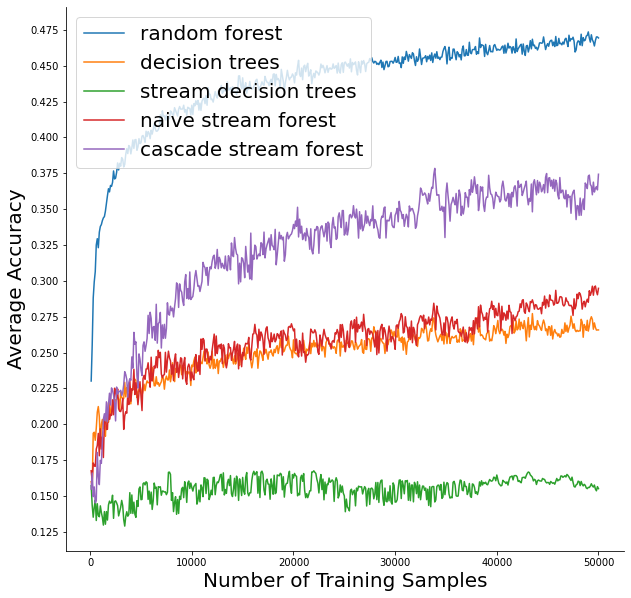

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

n_train = range(100, 50100, 100)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Number of Training Samples", fontsize=20)
ax.set_ylabel("Average Accuracy", fontsize=20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks(np.arange(0.1, 0.5, step=0.025))

plt.plot(n_train, means[0], label="random forest")
plt.plot(n_train, means[1], label="decision trees")
plt.plot(n_train, means[2], label="stream decision trees")
plt.plot(n_train, means[3], label="naive stream forest")
plt.plot(n_train, means[4], label="cascade stream forest")
plt.legend(fontsize=20)